<a href="https://colab.research.google.com/github/ksdkamesh99/LowLightEnhancer/blob/master/model_gradienttape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
cd /content/drive/My Drive/LowLightEnhancement

/content/drive/My Drive/LowLightEnhancement


In [67]:
import tensorflow as tf
import keras
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


In [68]:
img_high=np.load("image_high.npy")

In [69]:
img_low=np.load("image_low.npy")

In [70]:
img_low=img_low/255
img_high=img_high/255

In [71]:
img_high.shape

(1485, 96, 96, 3)

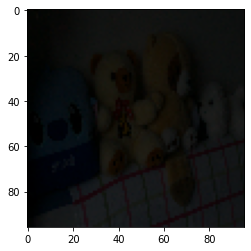

In [72]:
plt.imshow(img_low[0])

## Illumination Mask Network

In [73]:
input_layer_1=keras.layers.Input(shape=(96,96,3))

In [74]:
top=keras.layers.Conv2D(64,kernel_size=(3,3),input_shape=(96,96,3),padding='same')(input_layer_1)
top=keras.layers.Conv2D(64,kernel_size=(3,3),padding='same')(top)

In [75]:

top.get_shape

<bound method Tensor.get_shape of <tf.Tensor 'conv2d_32/BiasAdd:0' shape=(None, 96, 96, 64) dtype=float32>>

In [76]:

bottom_inp=input_layer_1
bottom_resize=tf.keras.layers.Lambda(
    lambda img: tf.image.resize(img,(60,60))
)(bottom_inp)

In [77]:
bottom=keras.layers.Conv2D(64,kernel_size=(3,3),input_shape=(60,60,3),padding='same')(bottom_resize)
bottom=keras.layers.Conv2D(64,kernel_size=(3,3),padding='same')(bottom)
bottom=keras.layers.Conv2D(64,kernel_size=(3,3),padding='same')(bottom)


In [78]:
bottom.get_shape()

TensorShape([None, 60, 60, 64])

In [79]:
bottom=keras.layers.experimental.preprocessing.Resizing(96,96)(bottom)

In [80]:
bottom.get_shape()

TensorShape([None, 96, 96, 64])

In [81]:
top.get_shape()

TensorShape([None, 96, 96, 64])

In [82]:
merged=keras.layers.concatenate([top,bottom])

In [83]:
merged

<tf.Tensor 'concatenate_8/concat:0' shape=(None, 96, 96, 128) dtype=float32>

In [84]:
merged=keras.layers.Conv2D(32,kernel_size=(7,7),padding='same')(merged)
merged=keras.layers.Conv2D(8,kernel_size=(1,1),padding='same')(merged)
merged=keras.layers.Conv2D(1,kernel_size=(5,5),activation='sigmoid',padding='same')(merged)

In [85]:
merged.get_shape()

TensorShape([None, 96, 96, 1])

In [86]:
model_illumination_mask=keras.models.Model(inputs=input_layer_1,outputs=merged)

In [87]:
model_illumination_mask.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
lambda_12 (Lambda)              (None, 60, 60, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 60, 60, 64)   1792        lambda_12[0][0]                  
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 60, 60, 64)   36928       conv2d_33[0][0]                  
_______________________________________________________________________________________

# Illumination Map 

In [88]:
merged.get_shape

<bound method Tensor.get_shape of <tf.Tensor 'conv2d_38/Sigmoid:0' shape=(None, 96, 96, 1) dtype=float32>>

In [89]:
merged=keras.layers.Concatenate()([input_layer_1,merged])

In [90]:
merged

<tf.Tensor 'concatenate_9/concat:0' shape=(None, 96, 96, 4) dtype=float32>

In [91]:
def ieb(input_feature):
  ieb1=keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu',padding='same')(input_feature)
  ieb1=keras.layers.Conv2D(32,kernel_size=(3,3),activation='relu',padding='same')(ieb1)
  max_pool=keras.layers.GlobalMaxPooling2D()(ieb1)
  avg_pool=keras.layers.GlobalAveragePooling2D()(ieb1)
  dense1=keras.layers.Dense(8,activation='relu')
  dense2=keras.layers.Dense(32,activation='sigmoid')
  max_pool=dense1(max_pool)
  max_pool=dense2(max_pool)
  avg_pool=dense1(avg_pool)
  avg_pool=dense2(avg_pool)
  '''max_pool=keras.layers.Lambda(
    lambda image: keras.backend.expand_dims(keras.backend.expand_dims(image,axis=1),axis=1))(max_pool)
  avg_pool=keras.layers.Lambda(
    lambda image: keras.backend.expand_dims(keras.backend.expand_dims(image,axis=1),axis=1))(avg_pool)'''
  channel=keras.layers.Add()([max_pool,avg_pool])
  ieb1=keras.layers.Multiply()([ieb1,channel])
  max_pool_s=tf.keras.layers.Lambda(
    lambda x: keras.backend.max(x,axis=3,keepdims=True))(ieb1)
  avg_pool_s=keras.layers.Lambda(
    lambda x: keras.backend.mean(x,axis=3,keepdims=True))(ieb1)
  concat_slayers=keras.layers.Concatenate(axis=3)([avg_pool_s,max_pool_s])
  spacial=keras.layers.Conv2D(1,7,activation='sigmoid',padding='same')(concat_slayers)
  #spacial=keras.layers.experimental.preprocessing.Resizing(92,92)(spacial)
  ieb1=keras.layers.Multiply()([ieb1,spacial])
  ieb1=keras.layers.BatchNormalization()(ieb1)
  ieb1=keras.layers.Activation('relu')(ieb1)
  #ieb1=keras.layers.experimental.preprocessing.Resizing(96,96)(ieb1)
  return ieb1


  



In [92]:
ieb_1=ieb(merged)

In [93]:
ieb_2=ieb(ieb_1)

In [94]:


ieb_3=ieb(ieb_2)

In [95]:
ieb_4=ieb(ieb_3)

In [96]:
ieb_5=ieb(ieb_4)

In [97]:
added_ieb=keras.layers.concatenate([ieb_1,ieb_2,ieb_3,ieb_4,ieb_5])

In [98]:
added_ieb

<tf.Tensor 'concatenate_15/concat:0' shape=(None, 96, 96, 160) dtype=float32>

In [99]:

impnet=keras.layers.Conv2D(32,(3,3),padding='same')(added_ieb)

In [100]:
impnet=keras.layers.Conv2D(8,(3,3),padding='same')(impnet)

In [101]:
impnet=keras.layers.Conv2D(1,(3,3),padding='same')(impnet)

# S/L Block 

In [102]:
'''impnet=keras.layers.Lambda(
    lambda x: x+keras.backend.constant(0.001)
)(impnet)'''

'impnet=keras.layers.Lambda(\n    lambda x: x+keras.backend.constant(0.001)\n)(impnet)'

In [103]:
s_l=keras.layers.Lambda(
    lambda input:input[0]/input[1]
)([input_layer_1,impnet])

In [104]:
s_l

<tf.Tensor 'lambda_23/truediv:0' shape=(None, 96, 96, 3) dtype=float32>

# Correction Network

In [105]:
def correction_network(input_feature):
  conv1=keras.layers.Conv2D(32,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(input_feature)
  conv2=keras.layers.Conv2D(32,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(conv1)
  conv3=keras.layers.Conv2D(16,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(conv2)
  conv4=keras.layers.Conv2D(16,kernel_size=(3,3),strides=(1,1),activation='relu',padding='same')(conv3)
  conv5=keras.layers.Conv2D(3,kernel_size=(3,3),strides=(1,1),activation='sigmoid',padding='same')(conv4)
  #conv5=keras.layers.experimental.preprocessing.Resizing(96,96)(conv5)
  #conv5=keras.layers.multiply([impnet,conv5])
  return conv5

In [106]:
final_output=correction_network(s_l)

# Custom Loss Function

In [107]:
import loss as l

In [108]:
import keras.backend as K

In [109]:
def enhancement_loss(x,y):
  x=K.cast(x,dtype='float32')
  y=K.cast(y,dtype='float32')
  norm=tf.norm(x-y)
  return norm

In [110]:

enhancement_loss(img_low[0],img_high[0])

<tf.Tensor: shape=(), dtype=float32, numpy=78.62597>

In [111]:

def color_loss(x,y):
  
  x=K.cast(x,dtype='float32')
  y=K.cast(y,dtype='float32')
  cosine_loss = keras.losses.CosineSimilarity()(x,y)
  colorloss=1-cosine_loss
  return colorloss

In [112]:
color_loss(img_low[0],img_high[0])

<tf.Tensor: shape=(), dtype=float32, numpy=1.9773979>

In [113]:
sobelFilter = K.variable([[[[1.,  1.]], [[0.,  2.]],[[-1.,  1.]]],
                      [[[2.,  0.]], [[0.,  0.]],[[-2.,  0.]]],
                      [[[1., -1.]], [[0., -2.]],[[-1., -1.]]]])


In [114]:
def expandedSobel(inputTensor):
    inputChannels = K.reshape(K.ones_like(inputTensor[0,0,0,:]),(1,1,-1,1))
    return sobelFilter * inputChannels



In [115]:
def squareSobelLoss(yTrue,yPred):
  
  yTrue=K.cast(yTrue,dtype='float32')
  yPred=K.cast(yPred,dtype='float32')
  filt = expandedSobel(yTrue)
  squareSobelTrue =K.square(K.depthwise_conv2d(yTrue,filt))
  squareSobelPred =K.square(K.depthwise_conv2d(yPred,filt))
  newShape = K.shape(squareSobelTrue)
  newShape = K.concatenate([newShape[:-1],
                              newShape[-1:]//2,
                              K.variable([2],dtype='int32')])
  squareSobelTrue = K.sum(K.reshape(squareSobelTrue,newShape),axis=-1)
  squareSobelPred = K.sum(K.reshape(squareSobelPred,newShape),axis=-1)
  return K.mean(K.abs(squareSobelTrue - squareSobelPred))


In [116]:
def MeanGradientError(outputs, targets):
    outputs=tf.cast(outputs,dtype='float32')
    targets=tf.cast(targets,dtype='float32')
    filter_x = tf.tile(tf.expand_dims(tf.constant([[-1, -2, -2], [0, 0, 0], [1, 2, 1]], dtype = 'float32'), axis = -1), [1, 1, outputs.shape[-1]])
    filter_x = tf.tile(tf.expand_dims(filter_x, axis = -1), [1, 1, 1, outputs.shape[-1]])
    filter_y = tf.tile(tf.expand_dims(tf.constant([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype = 'float32'), axis = -1), [1, 1, targets.shape[-1]])
    filter_y = tf.tile(tf.expand_dims(filter_y, axis = -1), [1, 1, 1, targets.shape[-1]])

    # output gradient
    output_gradient_x = tf.math.square(tf.nn.conv2d(outputs, filter_x, strides = 1, padding = 'SAME'))
    output_gradient_y = tf.math.square(tf.nn.conv2d(outputs, filter_y, strides = 1, padding = 'SAME'))

    #target gradient
    target_gradient_x = tf.math.square(tf.nn.conv2d(targets, filter_x, strides = 1, padding = 'SAME'))
    target_gradient_y = tf.math.square(tf.nn.conv2d(targets, filter_y, strides = 1, padding = 'SAME'))

    # square
    output_gradients = tf.math.sqrt(tf.math.add(output_gradient_x, output_gradient_y))
    target_gradients = tf.math.sqrt(tf.math.add(target_gradient_x, target_gradient_y))

    # compute mean gradient error
    shape = output_gradients.shape[1:3]
    mge = tf.math.reduce_sum(tf.math.squared_difference(output_gradients, target_gradients) / (shape[0] * shape[1]))
    return mge

In [117]:

def max_rgb_filter(img):
  # img=tf.keras.preprocessing.image.img_to_array(img)
  
  r=img[:,:,:,0]
  g=img[:,:,:,1]
  b=img[:,:,:,2]
  max_c=tf.maximum(K.maximum(r,g),b)
  '''
  b_broadcast = K.zeros(K.shape(r), dtype=r.dtype)
  bool_r=K.less(r,max)
  bool_g=K.less(g,max)
  bool_b=K.less(b,max)
  r=K.switch(bool_r,b_broadcast,r)
  g=K.switch(bool_g,b_broadcast,g)
  b=K.switch(bool_b,b_broadcast,b)
  # print(K.shape(r))
  r=K.expand_dims(r)
  g=K.expand_dims(g)
  b=K.expand_dims(b)
  img=K.concatenate([r,g,b],axis=-1)
  # print(K.shape(img))
  # img_rgb_filter=tf.keras.preprocessing.image.array_to_img(img)
  return img'''
  return tf.expand_dims(max_c,axis=-1)

def light_mask_loss(input_img,pred_img,true_img):
  pred_img=tf.cast(pred_img,tf.uint8)
  true_img=tf.cast(true_img,tf.uint8)
  input_img=tf.cast(input_img,tf.uint8)
  m_i=max_rgb_filter(input_img)
  m_t=max_rgb_filter(true_img)
  # m_t=m_t+K.constant(0.001,shape=m_t.shape,dtype=m_t.dtype)
  m_div_it=tf.divide(m_i,m_t)
  m_div_it=tf.cast(m_div_it,tf.uint8)
  light_mask=tf.subtract(pred_img,m_div_it)
  light_mask=tf.cast(light_mask,tf.float32)
  lightmask_loss=tf.norm(light_mask)
  return lightmask_loss

In [118]:
a1=max_rgb_filter(tf.expand_dims(img_low[1],axis=0))
a2=max_rgb_filter(tf.expand_dims(img_high[1],axis=0))

In [119]:
b=a1/a2
img_low[0]-b

<tf.Tensor: shape=(1, 96, 96, 3), dtype=float64, numpy=
array([[[[-0.00823529, -0.00039216, -0.01215686],
         [-0.00028011, -0.00420168, -0.00812325],
         [ 0.00571185, -0.00213129, -0.00997442],
         ...,
         [ 0.0246646 ,  0.03250774,  0.02858617],
         [ 0.02787493,  0.03571807,  0.02787493],
         [ 0.03443329,  0.03051172,  0.03051172]],

        [[-0.00951189, -0.00166875, -0.01343346],
         [-0.01096257, -0.00311943, -0.01096257],
         [-0.00472189,  0.00704282, -0.00472189],
         ...,
         [ 0.0302521 ,  0.0302521 ,  0.0302521 ],
         [ 0.00361991,  0.00361991,  0.01538462],
         [ 0.03051172,  0.03443329,  0.03051172]],

        [[-0.02039216, -0.02039216, -0.03215686],
         [ 0.01176471,  0.02352941,  0.01568627],
         [ 0.01176471,  0.02745098,  0.01568627],
         ...,
         [-0.02009804, -0.01617647, -0.02009804],
         [-0.0022409 ,  0.00560224,  0.00560224],
         [ 0.03963964,  0.03571807,  0.0317965 ]

In [120]:
def custom_loss_wrapper(input_tensor):
  def custom_loss(y_true,y_pred):
    # lm_loss=light_mask_loss(input_img=input_tensor,pred_img=y_pred,true_img=y_true)
    # print(lm_loss)
    e_loss=enhancement_loss(y_true,y_pred)
    c_loss=color_loss(y_true,y_pred)
    s_loss=squareSobelLoss(y_true,y_pred)
    total_loss=e_loss+s_loss*0.2+0.2*c_loss
    # total_loss=total_loss+(10*lm_loss)
    return total_loss
  return custom_loss

# Model

In [121]:
model=keras.models.Model(inputs=[input_layer_1],outputs=final_output)

In [122]:
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
lambda_12 (Lambda)              (None, 60, 60, 3)    0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 60, 60, 64)   1792        lambda_12[0][0]                  
__________________________________________________________________________________________________
conv2d_34 (Conv2D)              (None, 60, 60, 64)   36928       conv2d_33[0][0]                  
_______________________________________________________________________________________

# Plot a DL Model

In [123]:
# keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)

# Model Compile

In [124]:
opt=tf.optimizers.Adam()

In [133]:
EPOCHS=5
BATCH=28

In [134]:
import os

In [135]:

import random


In [141]:
for i in range(EPOCHS):
    b=0
    for j in range(0,img_high.shape[0],BATCH):
        b=b+1
        img_inp=img_low[j:j+BATCH]
        img_out=img_high[j:j+BATCH]
        with tf.GradientTape() as tape:
          img_pred=model([img_inp])
          lm_loss=light_mask_loss(input_img=img_inp,pred_img=img_pred,true_img=img_out)
          e_loss=enhancement_loss(img_out,img_pred)
          c_loss=color_loss(img_out,img_pred)
          s_loss=MeanGradientError(img_out,img_pred)
          total_loss=e_loss*3+s_loss*0.25+c_loss*1+lm_loss*5
          # according to paper:- total_loss=e_loss*1+s_loss*0.2+c_loss*1+lm_loss*10
          mse=tf.losses.mse(img_out,img_pred).numpy().sum()
        # os.system('cls')
          print(i,' ',b,' ',total_loss.numpy(),' ',mse)
          grads = tape.gradient(total_loss, model.trainable_variables)
          opt.apply_gradients(zip(grads, model.trainable_variables))




0   1   6042.354   13564.593
0   2   600.80817   12159.398
0   3   415.97028   5942.468
0   4   429.24628   6419.9565
0   5   7857.9478   9695.965
0   6   760.3909   19364.057
0   7   506.13464   8497.431
0   8   442.30066   6495.7964
0   9   423.39932   6011.8394
0   10   496.32544   8213.816
0   11   5880.18   7496.7534
0   12   488.8279   7848.591
0   13   342.77902   3914.345
0   14   13220.775   3991.5833
0   15   467.58896   7537.0137
0   16   367.03516   4611.749
0   17   22267.605   5598.503
0   18   56072.15   8863.324
0   19   76613.57   6416.212
0   20   18780.174   6483.159
0   21   89235.41   7246.7026
0   22   43886.75   5076.221
0   23   49906.867   6247.442
0   24   61171.348   5823.7896
0   25   72382.07   5837.366
0   26   25970.72   5654.4155
0   27   119179.87   5970.556
0   28   42955.254   4453.452
0   29   32456.232   4823.625
0   30   46274.445   4685.9824
0   31   67414.39   3494.8376
0   32   56972.3   4581.866
0   33   54089.61   5519.5215
0   34   136201.69 

In [142]:
import matplotlib.pyplot as plt

In [143]:
model

In [152]:
def high_light(index):
  img=np.expand_dims(img_low[index],axis=0)
  a=model([img])
  plt.imshow(img[0])
  plt.show()
  plt.imshow(a[0])
  plt.show()
  plt.imshow(img_high[index])
  plt.show()



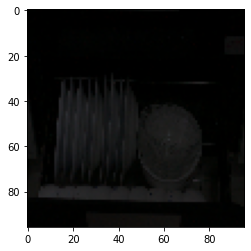

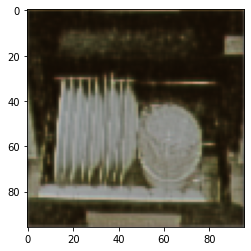

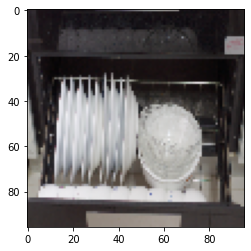

In [153]:
high_light(1)

In [154]:
model.save('model_improved.h5')